# **Step** 0: Setup Environment and import libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install pandas
!pip install seaborn

In [ ]:
# import libraries
import pandas as pd
import numpy as np
import pandas as pd
import sklearn.linear_model as lm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import linear_model

import torch
import torch.utils.data
from IPython import display
import torch.nn as nn
from sklearn.metrics import mean_squared_error
import sklearn

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
from PIL import Image

import matplotlib.image as mpimg
import numpy as np
import torchvision.models as models

from torchvision.datasets import ImageFolder
from PIL import Image

import pandas as pd
import torch.optim as optim

import sys
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.display import display,HTML
import requests, mimetypes
from PIL import Image
import requests
from io import BytesIO
import os

import datetime as dt

# **Step 1**: Data Preprocessing
Use dataset from https://osf.io/wsnzr/?view_only=319a53cf1bf542bbbe538aba37916537 and use only the Art Category data for our prediction model. Unnecessary columns are droped while some new columns are generated. Two new csv file are generated: Cleaned Art Data.csv and One Hot Cleaned Art Data.csv. 

In [ ]:
# filter art data
df = pd.read_csv('/content/drive/MyDrive/294/Data_API.csv')
categories = df["Category"].unique()
for category in categories:
    globals()[category.lower() + "_data"] = df[df["Category"] == category]

# find art NFTs that have been sold more than once
art_data_by_id = art_data.groupby("Unique_id_collection").count()
art_data_by_id = art_data_by_id[art_data_by_id["Collection_cleaned"] > 1]
ids_sold_more_than_once = art_data_by_id.index

# Construct a new dataframe that contains past transaction info
art_data_sold_more_than_once = art_data[art_data["Unique_id_collection"].isin(ids_sold_more_than_once)]
art_data_sold_more_than_once = art_data_sold_more_than_once.sort_values(["Unique_id_collection", "Datetime_updated_seconds"], ascending = True).reset_index()
art_data_sold_more_than_once["Past_Price_USD"] = [list(art_data_sold_more_than_once["Price_USD"])[-1]] + list(art_data_sold_more_than_once["Price_USD"])[0:-1]
art_data_sold_more_than_once["Past_Datetime_updated"] = [list(art_data_sold_more_than_once["Datetime_updated"])[-1]] + list(art_data_sold_more_than_once["Datetime_updated"])[0:-1]
art_data_sold_more_than_once["Days_Since_Last_Sell"] = pd.to_datetime(art_data_sold_more_than_once['Datetime_updated']) - pd.to_datetime(art_data_sold_more_than_once['Past_Datetime_updated'])
# art_data_sold_more_than_once = art_data_sold_more_than_once[["Unique_id_collection", "Image_url_1", "Collection_cleaned", "Past_Price_USD", "Price_USD", "Datetime_updated", "Days_Since_Last_Sell"]]
art_data_sold_more_than_once = art_data_sold_more_than_once[art_data_sold_more_than_once['Unique_id_collection'].duplicated()]

# filter out invalid urls
art_data_sold_more_than_once = art_data_sold_more_than_once[art_data_sold_more_than_once['Image_url_1'].str.contains("https", na=False)]
art_data_sold_more_than_once = art_data_sold_more_than_once.dropna().sample(n = 50000, replace = False)
art_data_sold_more_than_once = art_data_sold_more_than_once.reset_index().drop(columns = ["index"])
display(art_data_sold_more_than_once)

# Save it to CSV
# art_data_sold_more_than_once.to_csv('/content/drive/MyDrive/294/Art Sample.csv', index = False) 

In [ ]:
# create one hot 
data = pd.read_csv('/content/drive/MyDrive/294/Art Sample.csv')
data = data[["Unique_id_collection", "Image_url_1", "Collection_cleaned", "Past_Price_USD", "Price_USD", "Datetime_updated", "Days_Since_Last_Sell"]]
display(data)

def create_onehot(data, columns):
    columns = sorted(columns)
    for column in columns:
        values = data[column].unique()
        for value in values:
        # for value in values:
            data[column + "=" + str(value)] = (data[column] == value).astype(int)
        data = data.drop(column, axis = 1)
    return data
data = create_onehot(data, ["Collection_cleaned"])
data["Days_Since_Last_Sell"] = data["Days_Since_Last_Sell"].str.split(" ").str[0]
# data.to_csv('/content/drive/MyDrive/294/One Hot Sample.csv', index = False) 

In [ ]:
# helper function return boolean indicate whether or not it is a GIF
def not_GIF(url):
    r = requests.get(url)
    image_type = r.headers['Content-Type'].split("/")[-1]
    if image_type == "gif":
        return False
    else:
        return True

In [ ]:
# Visualize data: display image from the url
data = pd.read_csv('/content/drive/MyDrive/294/One Hot Sample.csv')

def path_to_image_html(path):
    return '<img src="'+ path + '" width="60" >'

pd.set_option('display.max_colwidth', None)
image_cols = ['Image_url_1']  #<- define which columns will be used to convert to html

# Create the dictionariy to be passed as formatters
format_dict = {}
for image_col in image_cols:
    format_dict[image_col] = path_to_image_html

display(HTML(data[:100].to_html(escape=False ,formatters=format_dict)))

In [ ]:
# # Save image for training
data = pd.read_csv('/content/drive/MyDrive/294/One Hot Sample.csv')
train_unique_image_ids = list(data["Unique_id_collection"].unique())
invalid_ids = []
destination = '/content/drive/MyDrive/294/Images'
for ID in train_unique_image_ids:
  try:
    url = data.loc[data.Unique_id_collection==ID].iloc[0,1]
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    nft_RGB = img.convert('RGB')
    nft_RGB.save(destination+'/'+ID+'.png')
  except:
    invalid_ids.append(ID)

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [ ]:
path = '/content/drive/MyDrive/294/Images'
print('filenum:',len([lists for lists in os.listdir(path) if os.path.isfile(os.path.join(path, lists))]))

filenum: 36471


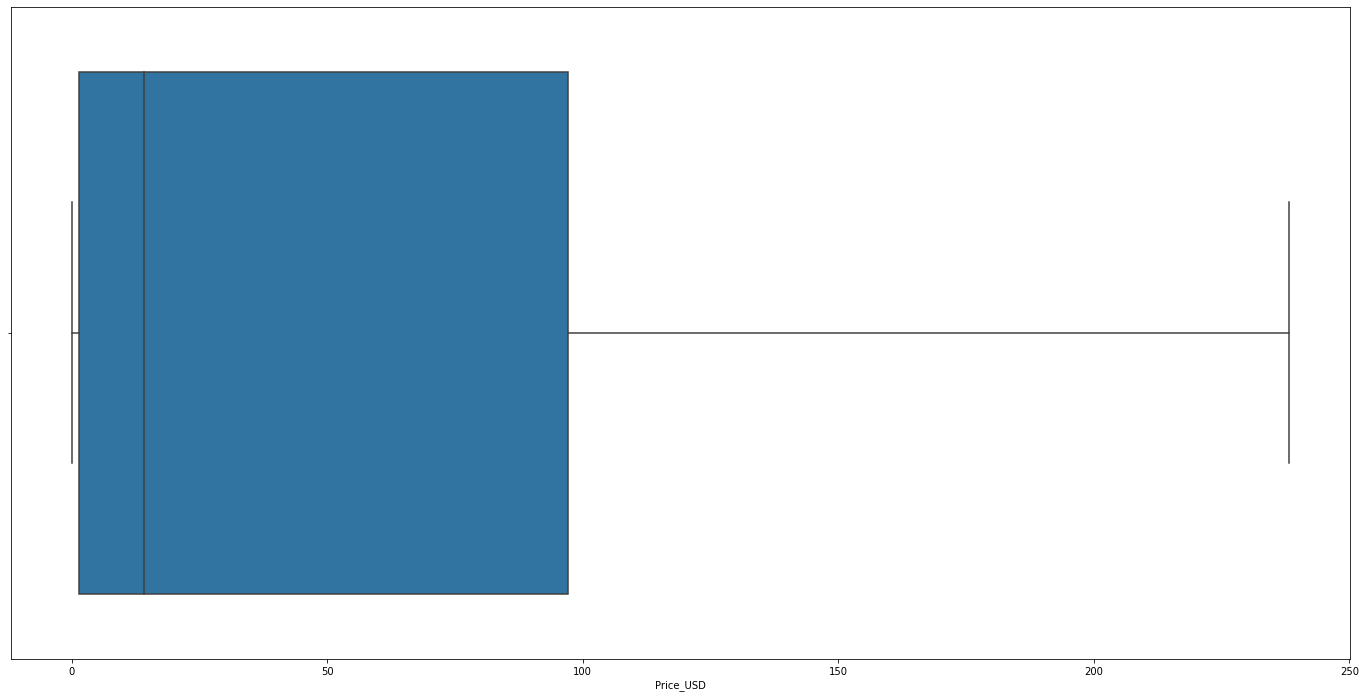

In [ ]:
# Generate Sampled Art NFTs Price Distributution Plot
plt.figure(figsize=(24,12))  
df = pd.read_csv('/content/drive/MyDrive/294/One Hot Sample.csv').iloc[:1000]
sns.boxplot(data=df, x='Price_USD',  showfliers = False)


# **Step 2**: Model Training (without image features extraction)
These following models will be used:

1. Linear Regression
*   without image info

2. Random Forest
*   without image info


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/294/AlexNet Data.csv').dropna()
X = data.iloc[:, :84]
X = X.drop(columns = ["Unique_id_collection", "Image_url_1", "Price_USD", "Image_path"])

# log transformation
X_past_price = np.log(data["Past_Price_USD"])
y = np.log(data["Price_USD"])

# Standardization
X = X.drop(columns = ["Past_Price_USD"])
transformer = sklearn.preprocessing.RobustScaler().fit(X)
X = transformer.transform(X)
X = np.column_stack((X, X_past_price))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle=True, random_state = 0)

# Remove outliears
X_train = pd.DataFrame(X_train)
y_train = y_train.reset_index(drop=True)
train_data_concat = pd.concat([X_train, y_train], axis = 1)
train_data_concat = train_data_concat[(train_data_concat['Price_USD'] >= np.percentile(train_data_concat['Price_USD'], 1)) & (train_data_concat['Price_USD'] <= np.percentile(train_data_concat['Price_USD'], 99))]
X_train = np.array(train_data_concat.drop(columns = ["Price_USD"]))
y_train = np.array(train_data_concat["Price_USD"])

In [ ]:
def ReLU(x):
  return np.maximum(x, 0, x)

def R_sqaured(actual, predict):
  corr_matrix = np.corrcoef(actual, predict)
  corr = corr_matrix[0,1]
  R_sq = corr**2
  return R_sq

def rmse(a, b):
    return float(np.sqrt(((a - b) ** 2).mean()))

## Linear regression with and without l1

In [ ]:
# without l1
from sklearn.linear_model import LinearRegression

lr = LinearRegression(fit_intercept = True, normalize = 'deprecated', copy_X = True, n_jobs = None, positive = False)
lr.fit(X_train, y_train)
r2_train = R_sqaured(np.exp(y_train), np.exp(lr.predict(X_train)))
r2_test = R_sqaured(np.exp(y_test), np.exp(lr.predict(X_test)))
r2_train_1 = R_sqaured((y_train), (lr.predict(X_train)))
r2_test_1 = R_sqaured((y_test), (lr.predict(X_test)))

print("Train R2:", r2_train)
print("Test R2:", r2_test)
print("Train R2 before log transform:", r2_train_1)
print("Test R2 before log transform:", r2_test_1)
print("Train RMSE: ", rmse(np.exp(y_train), np.exp(lr.predict(X_train))))
print("Test RMSE: ", rmse(np.exp(y_test), np.exp(lr.predict(X_test))))

Train R2: 0.5749130021752159
Test R2: 0.31111085752086987
Train R2 before log transform: 0.9127358911549781
Test R2 before log transform: 0.005589835952854143
Train RMSE:  457.60817448099095
Test RMSE:  2240.2431080337633


In [ ]:
# with l1
from sklearn.linear_model import Lasso
from sklearn.pipeline import make_pipeline

lr = Lasso(alpha=0.05, normalize = 'deprecated', max_iter=1000)
lr.fit(X_train, y_train)
r2_train = R_sqaured(np.exp(y_train), np.exp(lr.predict(X_train)))
r2_test = R_sqaured(np.exp(y_test), np.exp(lr.predict(X_test)))
r2_train_1 = R_sqaured((y_train), (lr.predict(X_train)))
r2_test_1 = R_sqaured((y_test), (lr.predict(X_test)))

print("Train R2:", r2_train)
print("Test R2:", r2_test)
print("Train R2 before log transform:", r2_train_1)
print("Test R2 before log transform:", r2_test_1)
print("Train RMSE: ", rmse(np.exp(y_train), np.exp(lr.predict(X_train))))
print("Test RMSE: ", rmse(np.exp(y_test), np.exp(lr.predict(X_test))))

Train R2: 0.4327041614330994
Test R2: 0.24490623367757133
Train R2 before log transform: 0.9023980010735688
Test R2 before log transform: 0.8549395708560634
Train RMSE:  507.10716678664704
Test RMSE:  2354.530747612105


## Random forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(max_depth = 15)
rf.fit(X_train, y_train)
r2_train = R_sqaured(np.exp(y_train), np.exp(rf.predict(X_train)))
r2_test = R_sqaured(np.exp(y_test), np.exp(rf.predict(X_test)))
r2_train_1 = R_sqaured((y_train), (rf.predict(X_train)))
print("Train R2:", r2_train)
print("Test R2:", r2_test)
print("Train R2 before log transform:", r2_train_1)
print("Test R2 before log transform:", r2_test_1)
print("Train RMSE: ", rmse(np.exp(y_train), np.exp(rf.predict(X_train))))
print("Test RMSE: ", rmse(np.exp(y_test), np.exp(rf.predict(X_test))))

Train R2: 0.868382342615532
Test R2: 0.16591656082341996
Train R2 before log transform: 0.9759245346036437
Test R2 before log transform: 0.8986533771237671
Train RMSE:  248.12882117546496
Test RMSE:  2441.6841200900685


# **Step 3**: Picture Feature Extraction using AlexNet


In [ ]:
class MyDataset(Dataset):
    def __init__(self, filenames, transform):
        self.filenames = filenames
        self.transform = transform
        
    def __len__(self):
        return len(self.filenames)
 
    # try except must included to handle the case where some images are not available (size too big!)
    def __getitem__(self, idx):
        try:
          image = Image.open(self.filenames[idx]).convert('RGB')
          image = self.transform(image)
        except:
          image = np.nan
        return image

In [ ]:
# 3 AlexNet 

# Load Data choose data segment
destination = '/content/drive/MyDrive/294/Images/'
data = pd.read_csv('/content/drive/MyDrive/294/One Hot Sample.csv')

# Convert datetime to number
data["Datetime_updated"] = pd.to_datetime(data["Datetime_updated"])
data["Datetime_updated"] = data["Datetime_updated"].map(dt.datetime.toordinal)

# Add new column to indicate the path to NFTs
data["Image_path"] = destination + data["Unique_id_collection"] + '.png'

# Define the number of classifiers after the Alexnet
NUM_OF_CLASS = 1000

# Define transformer
transformer = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    ])

# Setup dataloader
image_inputs = list(data["Image_path"])
image_dataset = MyDataset(image_inputs, transformer)
dataloader = DataLoader(image_dataset, shuffle = False)

# Define device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Setup Alexnet
alexnet = models.alexnet(pretrained = True)
alexnet.to(device)

# Pass each image in to the alexnet
Image_info = []
for i, (image) in enumerate(dataloader):
  try:
    # output_tensor = alexnet(image)
    output_tensor = alexnet(image.to(device))
    output_arr = output_tensor.detach().flatten().tolist()
    Image_info.append(output_arr)
  except:
    Image_info.append([np.nan] * NUM_OF_CLASS)

# Transpose the list in oreder to add them as columns to dataframe
Image_info = np.array(Image_info).T.tolist()

# Upadate dataframe
for i in range(NUM_OF_CLASS):
  data["Image_class_" + str(i)] = Image_info[i]
  
# display(data)
data.to_csv('/content/drive/MyDrive/294/AlexNet Data.csv', index = False) 

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


In [ ]:
# 3 EfficientNet

# Load Data choose data segment
destination = '/content/drive/MyDrive/294/Images/'
data = pd.read_csv('/content/drive/MyDrive/294/One Hot Sample.csv')

# Convert datetime to number
data["Datetime_updated"] = pd.to_datetime(data["Datetime_updated"])
data["Datetime_updated"] = data["Datetime_updated"].map(dt.datetime.toordinal)

# Add new column to indicate the path to NFTs
data["Image_path"] = destination + data["Unique_id_collection"] + '.png'

# Define the number of classifiers after the EfficientNet
NUM_OF_CLASS = 1000

# Define transformer
transformer = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    ])

# Setup dataloader
image_inputs = list(data["Image_path"])
image_dataset = MyDataset(image_inputs, transformer)
dataloader = DataLoader(image_dataset, shuffle = False)

# Define device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Setup EfficientNet
efficientnet_b7 = models.efficientnet_b7()
efficientnet_b7.to(device)

# Pass each image in to the EfficientNet
Image_info = []
for i, (image) in enumerate(dataloader):
  try:
    output_tensor = efficientnet_b7(image.to(device))
    output_arr = output_tensor.detach().flatten().tolist()
    Image_info.append(output_arr)
  except:
    Image_info.append([np.nan] * NUM_OF_CLASS)

# Transpose the list in oreder to add them as columns to dataframe
Image_info = np.array(Image_info).T.tolist()

# Upadate dataframe
for i in range(NUM_OF_CLASS):
  data["Image_class_" + str(i)] = Image_info[i]
  
data.to_csv('/content/drive/MyDrive/294/EfficientNet Data.csv', index = False) 

In [ ]:
# 3 ResNet

# Load Data choose data segment
destination = '/content/drive/MyDrive/294/Images/'
data = pd.read_csv('/content/drive/MyDrive/294/One Hot Sample.csv')

# Convert datetime to number
data["Datetime_updated"] = pd.to_datetime(data["Datetime_updated"])
data["Datetime_updated"] = data["Datetime_updated"].map(dt.datetime.toordinal)

# Add new column to indicate the path to NFTs
data["Image_path"] = destination + data["Unique_id_collection"] + '.png'

# Define the number of classifiers after the ResNet
NUM_OF_CLASS = 1000

# Define transformer
transformer = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    ])

# Setup dataloader
image_inputs = list(data["Image_path"])
image_dataset = MyDataset(image_inputs, transformer)
dataloader = DataLoader(image_dataset, shuffle = False)

# Define device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Setup EfficientNet
resnet50 = models.resnet50()
resnet50.to(device)

# Pass each image in to the EfficientNet
Image_info = []
for i, (image) in enumerate(dataloader):
  try:
    output_tensor = resnet50(image.to(device))
    output_arr = output_tensor.detach().flatten().tolist()
    Image_info.append(output_arr)
  except:
    Image_info.append([np.nan] * NUM_OF_CLASS)

# Transpose the list in oreder to add them as columns to dataframe
Image_info = np.array(Image_info).T.tolist()

# Upadate dataframe
for i in range(NUM_OF_CLASS):
  data["Image_class_" + str(i)] = Image_info[i]
  
# display(data)
data.to_csv('/content/drive/MyDrive/294/ResNet Data.csv', index = False) 

In [ ]:
print("pretrained = false")
children_counter = 0
alexnet = models.alexnet(pretrained = False)
for n,c in alexnet.named_children():
    print("Children Counter: ",children_counter," Layer Name: ",n,)
    children_counter+=1
display(alexnet._modules)

print("pretrained = true")
children_counter = 0
alexnet = models.alexnet(pretrained = True)
for n,c in alexnet.named_children():
    print("Children Counter: ",children_counter," Layer Name: ",n,)
    children_counter+=1
display(alexnet._modules)

print("pretrained = false")
children_counter = 0
efficientnet_b7 = models.efficientnet_b7(pretrained = False)
for n,c in efficientnet_b7.named_children():
    print("Children Counter: ",children_counter," Layer Name: ",n,)
    children_counter+=1
display(efficientnet_b7._modules)

print("pretrained = true")
children_counter = 0
efficientnet_b7 = models.efficientnet_b7(pretrained = True)
for n,c in efficientnet_b7.named_children():
    print("Children Counter: ",children_counter," Layer Name: ",n,)
    children_counter+=1
display(efficientnet_b7._modules)

print("pretrained = false")
children_counter = 0
resnet50 = models.resnet50(pretrained = False)
for n,c in resnet50.named_children():
    print("Children Counter: ",children_counter," Layer Name: ",n,)
    children_counter+=1
display(resnet50._modules)

print("pretrained = true")
children_counter = 0
resnet50 = models.resnet50(pretrained = True)
for n,c in resnet50.named_children():
    print("Children Counter: ",children_counter," Layer Name: ",n,)
    children_counter+=1
display(resnet50._modules)


# **Step 4**: Model Training (without image features extraction)

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/294/AlexNet Data.csv').dropna()
X = data.drop(columns = ["Unique_id_collection", "Image_url_1", "Price_USD", "Image_path"])
X_past_price = np.log(data["Past_Price_USD"])
y = np.log(data["Price_USD"])

# Standardization
X = X.drop(columns = ["Past_Price_USD"])
transformer = sklearn.preprocessing.RobustScaler().fit(X)
X = transformer.transform(X)
X = np.column_stack((X, X_past_price))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle=True, random_state = 42)

# Remove outliears
X_train = pd.DataFrame(X_train)
y_train = y_train.reset_index(drop=True)
train_data_concat = pd.concat([X_train, y_train], axis = 1)
train_data_concat = train_data_concat[(train_data_concat['Price_USD'] >= np.percentile(train_data_concat['Price_USD'], 1)) & (train_data_concat['Price_USD'] <= np.percentile(train_data_concat['Price_USD'], 99))]
X_train = np.array(train_data_concat.drop(columns = ["Price_USD"]))
y_train = np.array(train_data_concat["Price_USD"])

In [ ]:
# without l1
from sklearn.linear_model import LinearRegression

lr = LinearRegression(fit_intercept = True, normalize = 'deprecated', copy_X = True, n_jobs = None, positive = False)
lr.fit(X_train, y_train)
r2_train = R_sqaured(np.exp(y_train), np.exp(lr.predict(X_train)))
r2_test = R_sqaured(np.exp(y_test), np.exp(lr.predict(X_test)))
r2_train_1 = R_sqaured((y_train), (lr.predict(X_train)))
r2_test_1 = R_sqaured((y_test), (lr.predict(X_test)))

print("Train R2:", r2_train)
print("Test R2:", r2_test)
print("Train R2 before log transform:", r2_train_1)
print("Test R2 before log transform:", r2_test_1)
print("Train RMSE: ", rmse(np.exp(y_train), np.exp(lr.predict(X_train))))
print("Test RMSE: ", rmse(np.exp(y_test), np.exp(lr.predict(X_test))))

Train R2: 0.6161956183958905
Test R2: 0.5010648166954372
Train R2 before log transform: 0.9092284375553904
Test R2 before log transform: 0.0018372890264789906
Train RMSE:  417.7238111062014
Test RMSE:  1328.5491353490586


In [ ]:
# with l1
from sklearn.linear_model import Lasso
from sklearn.pipeline import make_pipeline

lr = Lasso(alpha=0.2, normalize = 'deprecated', max_iter=1000)
lr.fit(X_train, y_train)
r2_train = R_sqaured(np.exp(y_train), np.exp(lr.predict(X_train)))
r2_test = R_sqaured(np.exp(y_test), np.exp(lr.predict(X_test)))
r2_train_1 = R_sqaured((y_train), (lr.predict(X_train)))
r2_test_1 = R_sqaured((y_test), (lr.predict(X_test)))

print("Train R2:", r2_train)
print("Test R2:", r2_test)
print("Train R2 before log transform:", r2_train_1)
print("Test R2 before log transform:", r2_test_1)
print("Train RMSE: ", rmse(np.exp(y_train), np.exp(lr.predict(X_train))))
print("Test RMSE: ", rmse(np.exp(y_test), np.exp(lr.predict(X_test))))

Train R2: 0.43543399935775123
Test R2: 0.39574858692092096
Train R2 before log transform: 0.8849478384317103
Test R2 before log transform: 0.8914575505137756
Train RMSE:  493.32839416298566
Test RMSE:  1447.9929725582322


In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(max_depth = 5)
rf.fit(X_train, y_train)
r2_train = R_sqaured(np.exp(y_train), np.exp(rf.predict(X_train)))
r2_test = R_sqaured(np.exp(y_test), np.exp(rf.predict(X_test)))
r2_train_1 = R_sqaured((y_train), (rf.predict(X_train)))
r2_test_1 = R_sqaured((y_test), (rf.predict(X_test)))

print("Train R2:", r2_train)
print("Test R2:", r2_test)
print("Train R2 before log transform:", r2_train_1)
print("Test R2 before log transform:", r2_test_1)
print("Train RMSE: ", rmse(np.exp(y_train), np.exp(rf.predict(X_train))))
print("Test RMSE: ", rmse(np.exp(y_test), np.exp(rf.predict(X_test))))

Train R2: 0.8113539899127101
Test R2: 0.37097827911028464
Train R2 before log transform: 0.977251120829028
Test R2 before log transform: 0.8697831231377205
Train RMSE:  395.06384470431277
Test RMSE:  1646.8507429739973


In [ ]:
from sklearn.svm import SVR

svr = SVR(kernel='rbf', degree=3, gamma='scale', coef0=0.0, tol=1e-5, C=100, epsilon=0.1, shrinking=True, cache_size=200, verbose=False, max_iter=-1)
svr.fit(X_train, y_train)
r2_train = R_sqaured(np.exp(y_train), np.exp(svr.predict(X_train)))
r2_test = R_sqaured(np.exp(y_test), np.exp(svr.predict(X_test)))
r2_train_1 = R_sqaured((y_train), (svr.predict(X_train)))
r2_test_1 = R_sqaured((y_test), (svr.predict(X_test)))


print("Train R2:", r2_train)
print("Test R2:", r2_test)
print("Train R2 before log transform:", r2_train_1)
print("Test R2 before log transform:", r2_test_1)
print("Train RMSE: ", rmse(y_train, np.exp(svr.predict(X_train))))
print("Test RMSE: ", rmse(y_test, np.exp(svr.predict(X_test))))

In [ ]:
from sklearn.ensemble import AdaBoostRegressor

adaB = AdaBoostRegressor(base_estimator=None, n_estimators=100, learning_rate=1.0, loss='linear', random_state=None)
adaB.fit(X_train, y_train)
r2_train = R_sqaured(np.exp(y_train), np.exp(adaB.predict(X_train)))
r2_test = R_sqaured(np.exp(y_test), np.exp(adaB.predict(X_test)))
r2_train_1 = R_sqaured((y_train), (adaB.predict(X_train)))
r2_test_1 = R_sqaured((y_test), (adaB.predict(X_test)))


print("Train R2:", r2_train)
print("Test R2:", r2_test)
print("Train R2 before log transform:", r2_train_1)
print("Test R2 before log transform:", r2_test_1)
print("Train RMSE: ", rmse(np.exp(y_train), np.exp(adaB.predict(X_train))))
print("Test RMSE: ", rmse(np.exp(y_test), np.exp(adaB.predict(X_test))))

Train RMSE:  555.3592893127358
Test RMSE:  1759.7551508664537


In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

gdB = GradientBoostingRegressor(max_depth=5, max_features='auto', learning_rate=0.1)
gdB.fit(X_train, y_train)
r2_train = R_sqaured(np.exp(y_train), np.exp(gdB.predict(X_train)))
r2_test = R_sqaured(np.exp(y_test), np.exp(gdB.predict(X_test)))
r2_train_1 = R_sqaured((y_train), (gdB.predict(X_train)))
r2_test_1 = R_sqaured((y_test), (gdB.predict(X_test)))


print("Train R2:", r2_train)
print("Test R2:", r2_test)
print("Train R2 before log transform:", r2_train_1)
print("Test R2 before log transform:", r2_test_1)
print("Train RMSE: ", rmse(np.exp(y_train), np.exp(gdB.predict(X_train))))
print("Test RMSE: ", rmse(np.exp(y_test), np.exp(gdB.predict(X_test))))

Train R2: 0.7715933187091767
Test R2: 0.31727900982510865
Train R2 before log transform: 0.9570024941374665
Test R2 before log transform: 0.9001257410615332
Train RMSE:  328.0606683500023
Test RMSE:  1590.1283569401223


In [ ]:
from sklearn.neural_network import MLPRegressor

layers = (50,50,50,50,50,50,50)
mlp = MLPRegressor(hidden_layer_sizes=layers, alpha=1e-5, learning_rate_init=1e-4, learning_rate='constant', max_iter=500, batch_size=1000)
mlp.fit(X_train, y_train)
r2_train = R_sqaured(np.exp(y_train), np.exp(mlp.predict(X_train)))
r2_test = R_sqaured(np.exp(y_test), np.exp(mlp.predict(X_test)))
r2_train_1 = R_sqaured((y_train), (mlp.predict(X_train)))
r2_test_1 = R_sqaured((y_test), (mlp.predict(X_test)))


print("Train R2:", r2_train)
print("Test R2:", r2_test)
print("Train R2 before log transform:", r2_train_1)
print("Test R2 before log transform:", r2_test_1)
print("Train RMSE: ", rmse(np.exp(y_train), np.exp(mlp.predict(X_train))))
print("Test RMSE: ", rmse(np.exp(y_test), np.exp(mlp.predict(X_test))))

Train R2: 0.8113539899127101
Test R2: 0.37097827911028464
Train R2 before log transform: 0.977251120829028
Test R2 before log transform: 0.8697831231377205
Train RMSE:  282.77488473492633
Test RMSE:  1440.1435365937389
